<a href="https://colab.research.google.com/github/hardik0/Multi-Object-Tracking-Google-Colab/blob/main/Towards-Realtime-MOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Towards Realtime MOT
Joint Detection and Embedding (JDE) model. JDE is a fast and high-performance multiple-object tracker that learns the object detection task and appearance embedding task simutaneously in a shared neural network. Techical details are described in [ECCV 2020 paper](https://arxiv.org/pdf/1909.12605v1.pdf). 

**Original code :** [Towards-Realtime-MOT](https://github.com/Zhongdao/Towards-Realtime-MOT) by [@ZhongdaoWang](https://github.com/Zhongdao)

### Citation
```
@article{wang2019towards,
  title={Towards Real-Time Multi-Object Tracking},
  author={Wang, Zhongdao and Zheng, Liang and Liu, Yixuan and Wang, Shengjin},
  journal={arXiv preprint arXiv:1909.12605},
  year={2019}
}
```

In [ ]:
! nvidia-smi
! /usr/local/cuda/bin/nvcc --version

To access Google Drive Folder and Files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Inference
clone this repository

In [2]:
! git clone https://github.com/hardik0/Towards-Realtime-MOT
%cd Towards-Realtime-MOT

Cloning into 'Towards-Realtime-MOT'...
remote: Enumerating objects: 407, done.
remote: Total 407 (delta 0), reused 0 (delta 0), pack-reused 407
Receiving objects: 100% (407/407), 21.42 MiB | 53.49 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/Towards-Realtime-MOT


check torch version

In [ ]:
import torch
torch.__version__

'1.6.0+cu101'

Downgrade the PyTorch version to 1.2

In [ ]:
# uncomment below line ONLY if you run into any dependency issues while following
#! pip install torch==1.2.0 torchvision==0.4.0 cudatoolkit=10.0 -c pytorch

In [ ]:
import torch
torch.__version__

'1.2.0'

 Install the Dependencies

In [ ]:
! pip install motmetrics cython_bbox ffmpeg lap pillow

restart the runtime if required

In [ ]:
# change dir after restart
%cd Towards-Realtime-MOT/

### Download video from Youtube | Copy video from Google Drive

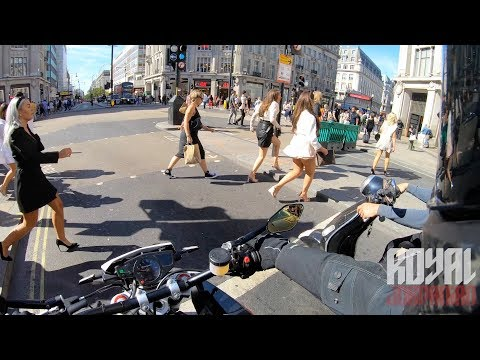

In [18]:
!pip install youtube-dl
from IPython.display import YouTubeVideo

YOUTUBE_ID = 'WriuvU1rXkc'

YouTubeVideo(YOUTUBE_ID)

In [ ]:
#!rm -rf youtube.mp4
# download the youtube with the given ID
! youtube-dl -f 22 --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

# cut the first 30 seconds
! ffmpeg -y -loglevel info -i youtube.mp4 -t 30 ped_track.mp4

### Download Pretrained model

In [ ]:
! mkdir models && mkdir outputs && wget -O utils/google_utils.py https://raw.githubusercontent.com/hardik0/Multi-Object-Tracking-Google-Colab/main/utils/google_utils.py
from utils.google_utils import *
#gdrive_download(id='', name='models/.pth')
gdrive_download(id='1nlnuYfGNuHWZztQHXwVZSL_FvfE551pA', name='models/jde.1088x608.uncertainty.pth')
gdrive_download(id='1UKgkYrsV-59kYaHgWeJ70p5Mij3QWuFr', name='models/jde_864x480_uncertainty.pth')
gdrive_download(id='1sca65sHMnxY7YJ89FJ6Dg3S3yAjbLdMz', name='models/jde_576x320_uncertainty.pth')

In [ ]:
%ls models/

### Run the demo

In [ ]:
! python demo.py --input-video ped_track.mp4 --weights models/jde.1088x608.uncertainty.pth \
                 --output-format video --output-root outputs/jde_1088X608_video

In [9]:
%ls outputs/jde_1088X608_video/

frame/  result.mp4  results.txt


rename result.mp4 file (optional)

In [ ]:
%mv outputs/jde_1088X608_video/result.mp4 outputs/jde_1088X608_video/ped_tracking_jde_1088X608_result.mp4

Reduce video size (optional)

In [15]:
! ffmpeg -y -loglevel panic -i outputs/jde_1088X608_video/result.mp4 outputs/jde_1088X608_video/ped_street_tracking_jde_1088X608_result.mp4

Copy video to google drive | download video from file browser (optional)

In [ ]:
%cp -r outputs/jde_1088X608_video/ped_tracking_jde_1088X608_result.mp4 '../gdrive/My Drive/Colab Notebooks/MOT/'

Playing videos on google colab

In [16]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('outputs/jde_1088X608_video/ped_street_tracking_jde_1088X608_result.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Training instruction
### Data Format
All the datasets have the following structure:

```
Caltech
   |——————images
   |        └——————00001.jpg
   |        |—————— ...
   |        └——————0000N.jpg
   └——————labels_with_ids
            └——————00001.txt
            |—————— ...
            └——————0000N.txt
```

Every image has a corresponding annotation text. Given an image path, the annotation text path can be generated by replacing the string `images` with `labels_with_ids` and replacing `.jpg` with `.txt`.

In the annotation text, each line is describing a bounding box and has the following format:

`[class] [identity] [x_center] [y_center] [width] [height]`

The field `[class]` should be `0`. Only single-class multi-object tracking is supported in this version.

The field `[identity]` is an integer from `0` to `num_identities - 1`, or `-1` if this box has no identity annotation.

***Note** that the values of `[x_center] [y_center] [width] [height]` are normalized by the width/height of the image, so they are floating point numbers ranging from 0 to 1.

### Download the training datasets.

* MOT-17

In [ ]:
! wget https://motchallenge.net/data/MOT17.zip
! unzip -q MOT17.zip -d data/MOT17/

* CityPersons

In [ ]:
from utils.google_utils import *
gdrive_download(id='1DgLHqEkQUOj63mCrS_0UGFEM9BG8sIZs', name='data/Citypersons.zip')
gdrive_download(id='1BH9Xz59UImIGUdYwUR-cnP1g7Ton_LcZ', name='data/Citypersons.z01')
gdrive_download(id='1q_OltirP68YFvRWgYkBHLEFSUayjkKYE', name='data/Citypersons.z02')
gdrive_download(id='1VSL0SFoQxPXnIdBamOZJzHrHJ1N2gsTW', name='data/Citypersons.z03')

In [ ]:
%%shell

mkdir data/MOT
cd data
zip -s- -qr Citypersons.zip -O Citypersons_all.zip
unzip -q Citypersons_all.zip -d MOT/
mv MOT/Citypersons MOT/Cityscapes
#rm -r data/*.z*

* CUHK-SYSU & PRW

In [ ]:
from utils.google_utils import *
#gdrive_download(id='1ET-6w12yHNo8DKevOVgK1dBlYs739e_3', name='MOT17.zip')
gdrive_download(id='116_mIdjgB-WJXGe8RYJDWxlFnc_4sqS8', name='data/PRW.zip')
gdrive_download(id='1D7VL43kIV9uJrdSCYl53j89RE2K-IoQA', name='data/CUHKSYSU.zip')

In [ ]:
%%shell

cd data
ls MOT
unzip -q PRW.zip -d MOT/
unzip -q CUHKSYSU.zip -d MOT/
mv MOT/CUHK-SYSU MOT/CUHKSYSU
rm -r *.zip
ls MOT

In [ ]:
!du -h data/MOT/

In [ ]:
! head data/prw.train

In [ ]:
! tail data/prw.val

In [ ]:
ls data/MOT

Cityscapes/  CUHKSYSU/  PRW/


mkdir on gdrive to save training model

In [ ]:
%mkdir '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT'
%ls '../gdrive/My Drive/Colab Notebooks/MOT/'

Download Darknet-53 ImageNet pretrained model: [DarkNet Official](https://pjreddie.com/media/files/darknet53.conv.74) | or download from gdrive

In [ ]:
%mkdir weights
! cp -r '../gdrive/My Drive/Colab Notebooks/MOT/darknet53.conv.74' weights/

copy yolo cfg file to train model with different input resolutions

In [ ]:
# uncomment below lines to train model with different resolutions
#! rm -r  cfg/yolov3.cfg    # default yolov3_1088x608
#! cp cfg/yolov3_1088x608.cfg cfg/yolov3.cfg    # yolov3_864x480, yolov3_576x320

edit cfg/ccmcpe.json file from file browser

In [ ]:
# edit ccmcpe.json
%cat cfg/ccmcpe.json

### Start Training

In [ ]:
! CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch train.py \
                                --cfg cfg/yolov3.cfg --data-cfg cfg/ccmcpe.json \
                                --batch-size 6 --print-interval 500 --save-model-after 2 \
                                --weights-to '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/'

dataset summary
OrderedDict([('prw', 933.0)])
total # identities: 934
start index
OrderedDict([('prw', 0)])
batch size ====== 6
2020-10-14 12:01:05 [INFO]:    Epoch       Batch       box      conf        id     total  nTargets      time
2020-10-14 12:01:17 [INFO]:     0/29       0/949     0.176      2.04      13.9       128        15      11.6
2020-10-14 12:12:17 [INFO]:     0/29     500/949    0.0962     0.847      17.4      65.7      18.7      1.31
dataset summary
OrderedDict([('prw', 934.0)])
total # identities: 935
start index
OrderedDict([('prw', 0)])
      Image      Total          P          R        mAP
/content/Towards-Realtime-MOT/utils/utils.py:444: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  v = v.nonzero().squeeze()
          6       2000          0          0          0      0.821s
        

In [ ]:
%ls '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/'

### Resume training
* use `--resume` & `--weights-from` argument
* change `--weights-from` file path accordingly e.g. `/path_to/Towards_Realtime_MOT/run12_10_09_15/'`
 

In [ ]:
# resume training 
 CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch train.py \
                                --cfg cfg/yolov3.cfg --data-cfg cfg/ccmcpe.json \
                                --batch-size 6 --print-interval 500 --save-model-after 2 \
                                --weights-to '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/' \
                                --resume --weights-from '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/run12_10_09_15/' 

## Train with custom datasets - To-Do list;
Adding custom datsets is quite simple, all you need to do is to organize your annotation files in the same format as in our training sets. Please refer to [DATASET_ZOO](https://github.com/Zhongdao/Towards-Realtime-MOT/blob/master/DATASET_ZOO.md).md for the dataset format.